## EXPERIMENT 1 TEMPORARY FILE

### IMPORT LIBRARIES

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
# import gower
from sklearn.neighbors import NearestNeighbors
from func import *
from helpers import *
import os
from pathlib import Path
import json
import yaml
import dask.dataframe as dd
import psycopg2

In [2]:
params_path = "/mnt/c/Users/nahomw/Desktop/from_mac/nahomworku/Desktop/uthealth/gra_project/synthetic-population/config/params.yaml"
with open(params_path) as file:
    params_ = yaml.safe_load(file)
input_path = params_['etl']['input']
output_path = params_['etl']['output']



In [3]:
for i in range (len(input_path)):
    dir_path = Path(input_path[i])
    print(dir_path.name)
    print(dir_path)

emergency
/mnt/c/Users/nahomw/Desktop/from_mac/nahomworku/Desktop/uthealth/gra_project/synthetic-population/data/raw/emergency
inpatient
/mnt/c/Users/nahomw/Desktop/from_mac/nahomworku/Desktop/uthealth/gra_project/synthetic-population/data/raw/inpatient
outpatient
/mnt/c/Users/nahomw/Desktop/from_mac/nahomworku/Desktop/uthealth/gra_project/synthetic-population/data/raw/outpatient


In [4]:
dfs = {}

for i in range(len(input_path)):
    dir_path = Path(input_path[i])
    
    # Find files
    file_grouper = [str(p) for p in dir_path.rglob("*.txt") if "GROUPER" in p.name]
    file_base = [str(p) for p in dir_path.rglob("*.txt") if "BASE_DATA_1" in p.name or "BASE_1" in p.name]

    # Grouper files
    if file_grouper:  # only concat if list not empty
        df_grouper = dd.concat([dd.read_csv(fp, sep="\t", dtype=str) for fp in file_grouper],
                               ignore_index=True, axis=0, interleave_partitions=True)
        dfs[f"df_grouper_{dir_path.name}"] = df_grouper
        print(f"..df_grouper_{dir_path.name} dataframe loaded and merged..")
    else:
        print(f"..No grouper files found in {dir_path.name}, skipping..")

    # Base files
    if file_base:  # only concat if list not empty
        df_base = dd.concat([dd.read_csv(fp, sep="\t", dtype=str) for fp in file_base],
                            ignore_index=True, axis=0, interleave_partitions=True)
        dfs[f"df_base_1_{dir_path.name}"] = df_base
        print(f"..df_base_1_{dir_path.name} dataframe loaded and merged..")
    else:
        print(f"..No base files found in {dir_path.name}, skipping..")

..df_grouper_emergency dataframe loaded and merged..
..df_base_1_emergency dataframe loaded and merged..
..df_grouper_inpatient dataframe loaded and merged..
..df_base_1_inpatient dataframe loaded and merged..
..df_grouper_outpatient dataframe loaded and merged..
..df_base_1_outpatient dataframe loaded and merged..


In [5]:
for dataset_type, ddf in dfs.items():
    print(dataset_type)

df_grouper_emergency
df_base_1_emergency
df_grouper_inpatient
df_base_1_inpatient
df_grouper_outpatient
df_base_1_outpatient


In [ ]:
for dataset_type, ddf in dfs.items():
    # Use output_base from params.yaml (not overwrite it)
    out_dir = Path(output_path[0]) / dataset_type / "output"
    out_dir.mkdir(parents=True, exist_ok=True)

    # Save parquet (recommended for big data)
    parquet_file = out_dir / f"{dataset_type}.parquet"
    print(f"Saving → {parquet_file}")

    ddf.to_parquet(
        parquet_file,
        engine="pyarrow",
        overwrite=True,
        write_index=False  # do not save index column
    )

    print(f"✅ Saved {dataset_type} → {parquet_file}")


Saving → /mnt/c/Users/nahomw/Desktop/from_mac/nahomworku/Desktop/uthealth/gra_project/synthetic-population/data/bronze/df_grouper_emergency/output/df_grouper_emergency.parquet
✅ Saved df_grouper_emergency → /mnt/c/Users/nahomw/Desktop/from_mac/nahomworku/Desktop/uthealth/gra_project/synthetic-population/data/bronze/df_grouper_emergency/output/df_grouper_emergency.parquet
Saving → /mnt/c/Users/nahomw/Desktop/from_mac/nahomworku/Desktop/uthealth/gra_project/synthetic-population/data/bronze/df_base_1_emergency/output/df_base_1_emergency.parquet
✅ Saved df_base_1_emergency → /mnt/c/Users/nahomw/Desktop/from_mac/nahomworku/Desktop/uthealth/gra_project/synthetic-population/data/bronze/df_base_1_emergency/output/df_base_1_emergency.parquet
Saving → /mnt/c/Users/nahomw/Desktop/from_mac/nahomworku/Desktop/uthealth/gra_project/synthetic-population/data/bronze/df_grouper_inpatient/output/df_grouper_inpatient.parquet
✅ Saved df_grouper_inpatient → /mnt/c/Users/nahomw/Desktop/from_mac/nahomworku/De

: 

##### CONNECT TO DATABASE POSTGRES

In [ ]:
[dd.read_csv(fp, sep="\t", dtype=str) for fp in file_grouper]

In [13]:
from sqlalchemy import create_engine
hostname = params_['database']['hostname']
username = params_['database']['username']
password = params_['database']['password']
port = params_['database']['port']
database = params_['database']['database']
cur = None
conn = None
engine = create_engine(f"postgresql+psycopg2://{username}:{password}@{hostname}:{port}/{database}")

for table_name, ddf in dfs.items():
    # write each partition to CSV
    file_path = f"/tmp/{table_name}.csv"
    ddf.to_csv(file_path, single_file=True, index=False)

    # now use COPY to load into Postgres
    with engine.begin() as conn:
        conn.execute(f"""
            COPY {table_name}
            FROM '{file_path}'
            DELIMITER ','
            CSV HEADER;
        """)
    print(f"🚀 Loaded {table_name} into Postgres via COPY")


: 

In [ ]:
params_

In [52]:
for i,(name,df) in enumerate (dfs.items()):
    print(name,pd.DataFrame(df))

: 

In [8]:
df_base.shape[0].compute()

1786818

In [2]:
df_base_1 = pd.read_csv("/mnt/c/Users/nahomw/Desktop/from_mac/nahomworku/Desktop/uthealth/gra_project/synthetic-population/data/raw/emergency/ED PUDF 1Q2023 tab-delimited (2)/IP_ED_BASE_DATA_1_1q2023_tab.txt",sep="\t", dtype=str)
df_base_2 = pd.read_csv("/mnt/c/Users/nahomw/Desktop/from_mac/nahomworku/Desktop/uthealth/gra_project/synthetic-population/data/raw/emergency/ED PUDF 2Q2023 tab-delimited/IP_ED_BASE_DATA_1_2q2023_tab.txt",sep="\t", dtype=str)
df_base_3 = pd.read_csv("/mnt/c/Users/nahomw/Desktop/from_mac/nahomworku/Desktop/uthealth/gra_project/synthetic-population/data/raw/emergency/ED PUDF 3Q2023 tab-delimited/IP_ED_BASE_DATA_1_3q2023_tab.txt",sep="\t", dtype=str)
df_base_4 = pd.read_csv("/mnt/c/Users/nahomw/Desktop/from_mac/nahomworku/Desktop/uthealth/gra_project/synthetic-population/data/raw/emergency/ED PUDF 4Q2023 tab-delimited/IP_ED_BASE_DATA_1_4q2023_tab.txt",sep="\t", dtype=str)

df_grouper_1 = pd.read_csv("/mnt/c/Users/nahomw/Desktop/from_mac/nahomworku/Desktop/uthealth/gra_project/synthetic-population/data/raw/emergency/ED PUDF 1Q2023 tab-delimited (2)/IP_ED_GROUPER_1q2023_tab.txt",sep="\t", dtype=str)
df_grouper_2 = pd.read_csv("/mnt/c/Users/nahomw/Desktop/from_mac/nahomworku/Desktop/uthealth/gra_project/synthetic-population/data/raw/emergency/ED PUDF 2Q2023 tab-delimited/IP_ED_GROUPER_2q2023_tab.txt",sep="\t", dtype=str)
df_grouper_3 = pd.read_csv("/mnt/c/Users/nahomw/Desktop/from_mac/nahomworku/Desktop/uthealth/gra_project/synthetic-population/data/raw/emergency/ED PUDF 3Q2023 tab-delimited/IP_ED_GROUPER_3q2023_tab.txt",sep="\t", dtype=str)
df_grouper_4 = pd.read_csv("/mnt/c/Users/nahomw/Desktop/from_mac/nahomworku/Desktop/uthealth/gra_project/synthetic-population/data/raw/emergency/ED PUDF 4Q2023 tab-delimited/IP_ED_GROUPER_4q2023_tab.txt",sep="\t", dtype=str)

In [3]:
df_base = pd.concat([df_base_1, df_base_2])
df_base = pd.concat([df_base, df_base_3])
df_base = pd.concat([df_base, df_base_4])

# df_base.shape, df_base_1.shape,df_base_2.shape, df_base_3.shape,df_base_4.shape
df_grouper = pd.concat([df_grouper_1, df_grouper_2])
df_grouper = pd.concat([df_grouper, df_grouper_3])
df_grouper = pd.concat([df_grouper, df_grouper_4])




In [30]:
df_inp_base_1 = pd.read_csv("/mnt/c/Users/nahomw/Desktop/from_mac/nahomworku/Desktop/uthealth/gra_project/synthetic-population/data/raw/inpatient/PUDF 1Q2023 tab-delimited/IP_PUDF_BASE_DATA_1_1q2023_tab.txt",
    sep="\t",
    dtype=str
)


In [32]:
df_base_1.head()

,RECORD_ID,DISCHARGE,THCIC_ID,TYPE_OF_ADMISSION,SOURCE_OF_ADMISSION,SPEC_UNIT_1,SPEC_UNIT_2,SPEC_UNIT_3,SPEC_UNIT_4,SPEC_UNIT_5,...,OTH_SURG_PROC_DAY_22,OTH_SURG_PROC_CODE_23,OTH_SURG_PROC_DAY_23,OTH_SURG_PROC_CODE_24,OTH_SURG_PROC_DAY_24,ATTENDING_PHYSICIAN_UNIF_ID,OPERATING_PHYSICIAN_UNIF_ID,ENCOUNTER_INDICATOR,PROVIDER_NAME,EMERGENCY_DEPT_FLAG
0,120232073717,2023Q1,797101,1,9,B,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,9309093333,9309093333,01,Womens Hospital-Renaissance,Y
1,120232073719,2023Q1,797101,1,9,B,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,6076741216,8213325511,01,Womens Hospital-Renaissance,Y
2,120232073722,2023Q1,797101,1,9,B,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,9309093333,9309093333,01,Womens Hospital-Renaissance,Y
3,120232073725,2023Q1,797101,1,9,B,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,9807090664,9807090664,01,Womens Hospital-Renaissance,Y
4,120232073729,2023Q1,797101,1,9,B,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2563692158,2563692158,01,Womens Hospital-Renaissance,Y


In [ ]:
df_inp_base_1.shape, df_base_1.shape

((790235, 157), (443443, 157))

: 

In [4]:
df_ = pd.merge(df_base, df_grouper, on='RECORD_ID')
df = df_[['RECORD_ID', 'DISCHARGE', 'TYPE_OF_ADMISSION', 'SOURCE_OF_ADMISSION',
       'PAT_ZIP', 'PAT_COUNTY', 'PUBLIC_HEALTH_REGION', 'PAT_STATUS','SEX_CODE', 'RACE', 'ETHNICITY', 'ADMIT_WEEKDAY', 'LENGTH_OF_STAY','ILLNESS_SEVERITY',
       'PAT_AGE', 'FIRST_PAYMENT_SRC', 'APR_MDC']]
df.head()

,RECORD_ID,DISCHARGE,TYPE_OF_ADMISSION,SOURCE_OF_ADMISSION,PAT_ZIP,PAT_COUNTY,PUBLIC_HEALTH_REGION,PAT_STATUS,SEX_CODE,RACE,ETHNICITY,ADMIT_WEEKDAY,LENGTH_OF_STAY,ILLNESS_SEVERITY,PAT_AGE,FIRST_PAYMENT_SRC,APR_MDC
0,120232073717,2023Q1,1,9,78538,215,11,01,F,4,1,5,0002,1,09,CI,14
1,120232073719,2023Q1,1,9,78577,215,11,01,F,4,1,3,0002,1,08,HM,14
2,120232073722,2023Q1,1,9,78573,215,11,01,F,4,1,3,0003,1,07,MC,14
3,120232073725,2023Q1,1,9,78582,427,11,01,F,4,1,3,0004,1,07,HM,14
4,120232073729,2023Q1,1,9,78573,215,11,01,F,4,1,3,0003,2,10,BL,14


In [5]:
df.columns 

Index(['RECORD_ID', 'DISCHARGE', 'TYPE_OF_ADMISSION', 'SOURCE_OF_ADMISSION',
       'PAT_ZIP', 'PAT_COUNTY', 'PUBLIC_HEALTH_REGION', 'PAT_STATUS',
       'SEX_CODE', 'RACE', 'ETHNICITY', 'ADMIT_WEEKDAY', 'LENGTH_OF_STAY',
       'ILLNESS_SEVERITY', 'PAT_AGE', 'FIRST_PAYMENT_SRC', 'APR_MDC'],
      dtype='object')

In [6]:
cat_cols = df[['DISCHARGE', 'TYPE_OF_ADMISSION', 'SOURCE_OF_ADMISSION','ILLNESS_SEVERITY','PUBLIC_HEALTH_REGION', 'PAT_STATUS','SEX_CODE', 'RACE', 'ETHNICITY', 'ADMIT_WEEKDAY', 'LENGTH_OF_STAY','PAT_AGE', 'APR_MDC']]
le = LabelEncoder()

In [7]:
le.fit_transform(df['SEX_CODE']).dtype

dtype('int64')

In [8]:
# df[cat_cols].isnull().sum()
df.columns

Index(['RECORD_ID', 'DISCHARGE', 'TYPE_OF_ADMISSION', 'SOURCE_OF_ADMISSION',
       'PAT_ZIP', 'PAT_COUNTY', 'PUBLIC_HEALTH_REGION', 'PAT_STATUS',
       'SEX_CODE', 'RACE', 'ETHNICITY', 'ADMIT_WEEKDAY', 'LENGTH_OF_STAY',
       'ILLNESS_SEVERITY', 'PAT_AGE', 'FIRST_PAYMENT_SRC', 'APR_MDC'],
      dtype='object')

In [9]:
df.replace('`', np.nan, inplace=True)
df.replace('', np.nan, inplace=True)
df.dropna(inplace=True)
df.shape

/tmp/ipykernel_303938/3434238071.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace('`', np.nan, inplace=True)
/tmp/ipykernel_303938/3434238071.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace('', np.nan, inplace=True)
/tmp/ipykernel_303938/3434238071.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


(1529173, 17)

In [10]:
# import pandas as pd
# import numpy as np
# import gower
# from sklearn.neighbors import NearestNeighbors
# import matplotlib.pyplot as plt

# # Suppose df is your dataframe with categorical + numeric features
# # Compute Gower distance matrix
# gower_dist = gower.gower_matrix(df)

# # Choose k (same as min_samples for DBSCAN, e.g., 5)
# k = 5  
# neighbors = NearestNeighbors(n_neighbors=k, metric="precomputed")
# neighbors_fit = neighbors.fit(gower_dist)
# distances, indices = neighbors_fit.kneighbors(gower_dist)

# # Take the distance to the k-th nearest neighbor (last column)
# k_dist = np.sort(distances[:, k-1])

# # Plot k-distance graph
# plt.figure(figsize=(8,5))
# plt.plot(k_dist)
# plt.ylabel(f"Distance to {k}-th nearest neighbor")
# plt.xlabel("Points sorted by distance")
# plt.title("k-distance plot for DBSCAN (Gower metric)")
# plt.grid(True)
# plt.show()


In [16]:
df['APR_MDC'].value_counts()

APR_MDC
05    237387
18    203718
04    168560
06    141933
14    141174
01    122690
11    116515
08    108460
10     68181
07     62654
09     35786
16     28290
21     19461
19     16410
03     16264
17      8964
25      8455
23      6856
13      6701
12      3639
02      3168
15      2378
22      1473
00        33
20        23
Name: count, dtype: int64

### GLOBAL MODEL

In [7]:
df.columns

NameError: name 'df' is not defined

In [12]:
df.drop(columns=['RECORD_ID','FIRST_PAYMENT_SRC'], inplace = True)

/tmp/ipykernel_303938/4202868097.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['RECORD_ID','FIRST_PAYMENT_SRC'], inplace = True)


In [13]:
df.head()

,DISCHARGE,TYPE_OF_ADMISSION,SOURCE_OF_ADMISSION,PAT_ZIP,PAT_COUNTY,PUBLIC_HEALTH_REGION,PAT_STATUS,SEX_CODE,RACE,ETHNICITY,ADMIT_WEEKDAY,LENGTH_OF_STAY,ILLNESS_SEVERITY,PAT_AGE,APR_MDC
0,2023Q1,1,9,78538,215,11,01,F,4,1,5,0002,1,09,14
1,2023Q1,1,9,78577,215,11,01,F,4,1,3,0002,1,08,14
2,2023Q1,1,9,78573,215,11,01,F,4,1,3,0003,1,07,14
3,2023Q1,1,9,78582,427,11,01,F,4,1,3,0004,1,07,14
4,2023Q1,1,9,78573,215,11,01,F,4,1,3,0003,2,10,14


In [14]:
import pandas as pd

# Convert everything to numeric if possible
df = df.apply(pd.to_numeric, errors="ignore")

# If still object columns remain, map them manually (like SEX_CODE = F/M)
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].astype("category").cat.codes


/tmp/ipykernel_303938/534460970.py:4: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors="ignore")


/mnt/c/Users/nahomw/Desktop/from_mac/nahomworku/Desktop/uthealth/gra_project/synthetic-population/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/mnt/c/Users/nahomw/Desktop/from_mac/nahomworku/Desktop/uthealth/gra_project/synthetic-population/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/mnt/c/Users/nahomw/Desktop/from_mac/nahomworku/Desktop/uthealth/gra_project/synthetic-population/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: U

Accuracy: 0.3360504847385028
classification_report.              precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.29      0.10      0.15     24504
           2       0.00      0.00      0.00       643
           3       0.24      0.00      0.01      3229
           4       0.33      0.30      0.31     33531
           5       0.26      0.59      0.36     47653
           6       0.22      0.13      0.17     28504
           7       0.19      0.00      0.01     12797
           8       0.36      0.34      0.35     21558
           9       0.16      0.00      0.00      7135
          10       0.22      0.05      0.08     13652
          11       0.19      0.03      0.06     23316
          12       0.00      0.00      0.00       744
          13       0.00      0.00      0.00      1322
          14       0.66      0.96      0.79     27880
          15       0.56      0.90      0.69       449
          16       0.27      0

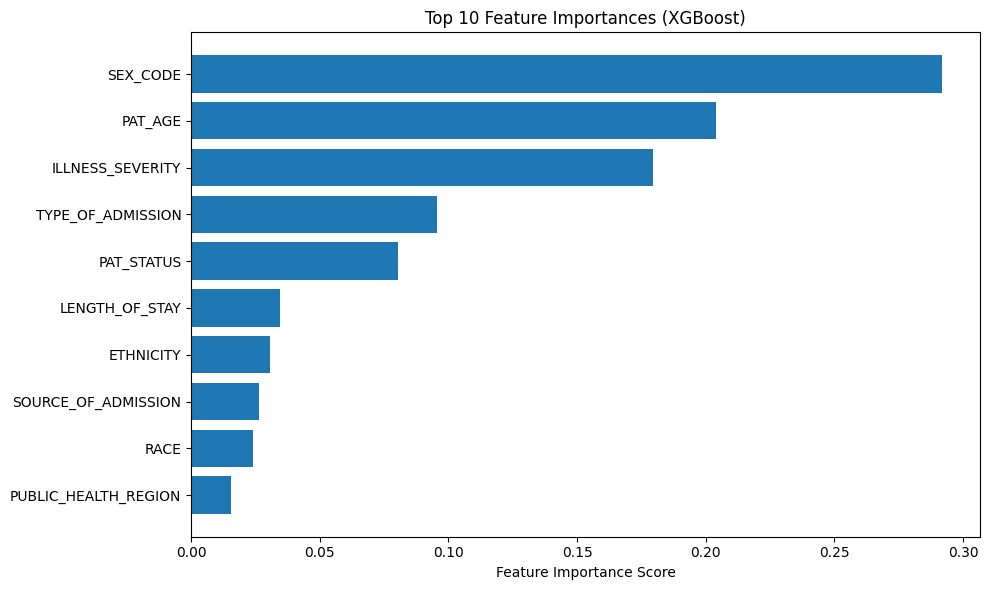

In [15]:
# Main block
def run_main(df):
    if __name__ == "__main__":
        X, y = preprocess(df)
        y_enc = le.fit_transform(y)
        X.dtypes, y_enc.dtype
        # X_pca = preprocess_pca(X)
        model = XGBClassifier(
        objective='multi:softprob',
        # n_estimators=200,
        # learning_rate=0.001,
        # max_depth=15,
        random_state=42,
        enable_categorical=True,
        eval_metric='mlogloss'
    )
        # model = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)
        model, X_test, y_test = train_model(model, X, y_enc)
        df_preds = eval_model(model, X_test, y_test)
        return df_preds
df_preds = run_main(df)
# plt.hist(preds)

(array([  8757.,  30677., 126446.,  20848.,   7151.,  40571.,   2024.,
         67503.,    793.,   1065.]),
 array([ 0. ,  2.4,  4.8,  7.2,  9.6, 12. , 14.4, 16.8, 19.2, 21.6, 24. ]),
 <BarContainer object of 10 artists>)

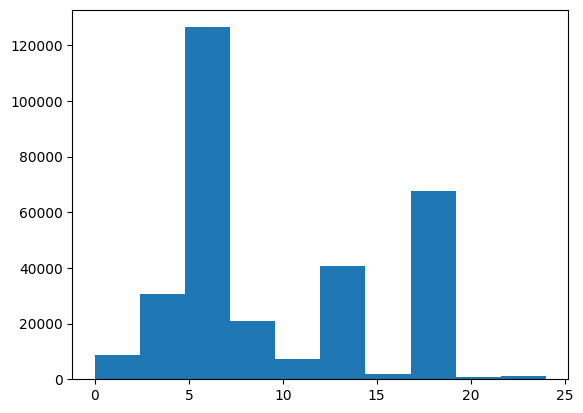

In [16]:
import matplotlib.pyplot as plt
# plt.hist(df_preds["pred"])
plt.hist(df_preds['pred'])

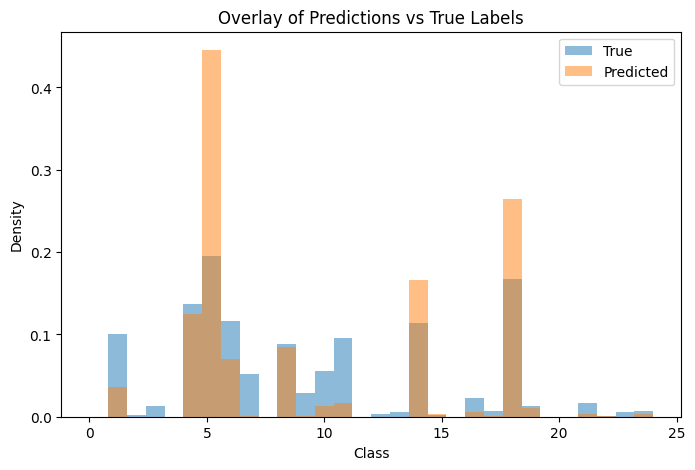

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(df_preds['y_test'], bins=30, alpha=0.5, label="True", density=True)
plt.hist(df_preds['pred'], bins=30, alpha=0.5, label="Predicted", density=True)

plt.xlabel("Class")
plt.ylabel("Density")
plt.title("Overlay of Predictions vs True Labels")
plt.legend()
plt.show()


In [18]:
from scipy.spatial.distance import jensenshannon
p = df_preds['pred'] 
q = df_preds['y_test'] 

js = jensenshannon(p, q)
print("JS Divergence:", js)


JS Divergence: 0.2630497197778324


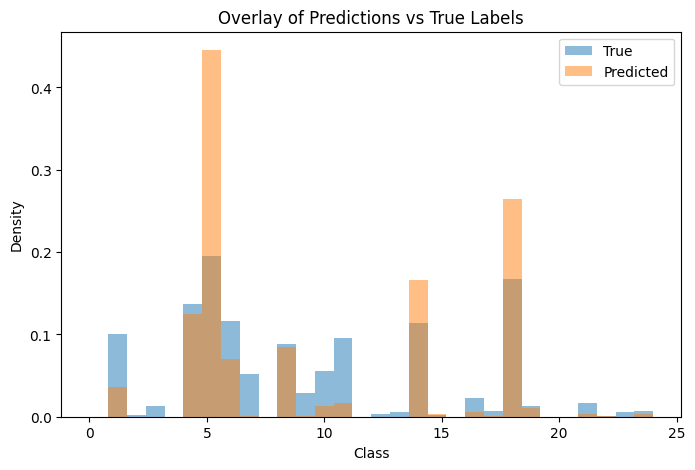

Jenson Shannon 0.2630497197778324


In [19]:
dist_match(data = df_preds['y_test'], pred = df_preds['pred'])

### CLASSIFICATION AND PREDICTION OF SUBGROUPS

In [20]:
df.columns

Index(['DISCHARGE', 'TYPE_OF_ADMISSION', 'SOURCE_OF_ADMISSION', 'PAT_ZIP',
       'PAT_COUNTY', 'PUBLIC_HEALTH_REGION', 'PAT_STATUS', 'SEX_CODE', 'RACE',
       'ETHNICITY', 'ADMIT_WEEKDAY', 'LENGTH_OF_STAY', 'ILLNESS_SEVERITY',
       'PAT_AGE', 'APR_MDC'],
      dtype='object')

In [21]:
df['PAT_AGE'] = df['PAT_AGE'].astype(float)
df['PAT_AGE'].value_counts().count()
df['ILLNESS_SEVERITY'].value_counts()

# df.columns

ILLNESS_SEVERITY
2    567144
3    469447
1    285786
4    204428
0      2368
Name: count, dtype: int64

In [22]:
### Return value counts by icd-10 codes
df_sub = df[df['ILLNESS_SEVERITY'] ==  2]
df_sub['APR_MDC'].value_counts()

APR_MDC
5     88885
6     57654
14    55212
8     50297
1     50165
11    49212
18    48616
4     44990
10    31280
7     24192
9     16988
16    11054
19     9528
21     7556
3      6608
13     3153
23     2988
17     2402
25     1864
12     1668
2      1511
15      761
22      551
20        8
0         1
Name: count, dtype: int64

/mnt/c/Users/nahomw/Desktop/from_mac/nahomworku/Desktop/uthealth/gra_project/synthetic-population/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/mnt/c/Users/nahomw/Desktop/from_mac/nahomworku/Desktop/uthealth/gra_project/synthetic-population/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/mnt/c/Users/nahomw/Desktop/from_mac/nahomworku/Desktop/uthealth/gra_project/synthetic-population/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: U

Accuracy: 0.3222544499202144
classification_report.              precision    recall  f1-score   support

           1       0.32      0.12      0.17     10052
           2       0.00      0.00      0.00       301
           3       0.18      0.00      0.00      1294
           4       0.48      0.23      0.32      8974
           5       0.25      0.75      0.38     17710
           6       0.16      0.09      0.12     11566
           7       0.09      0.00      0.01      4819
           8       0.34      0.44      0.39     10057
           9       0.12      0.00      0.00      3370
          10       0.22      0.09      0.12      6294
          11       0.17      0.04      0.07      9791
          12       0.00      0.00      0.00       357
          13       0.06      0.00      0.01       669
          14       0.63      0.97      0.77     11138
          15       0.57      0.78      0.66       152
          16       0.21      0.04      0.07      2184
          17       0.25      0

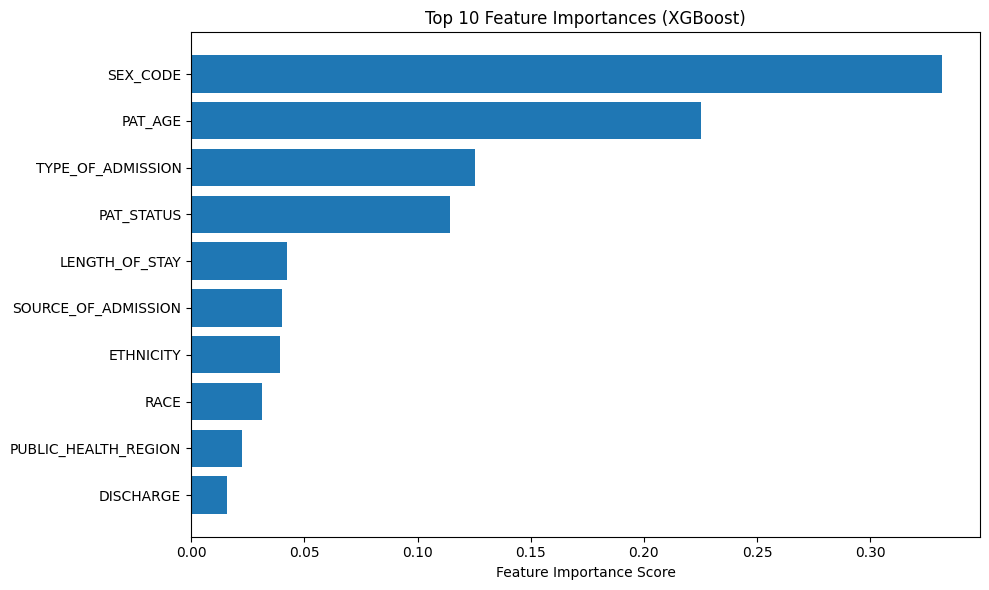

In [23]:
df_pred_sub = run_main(df_sub)

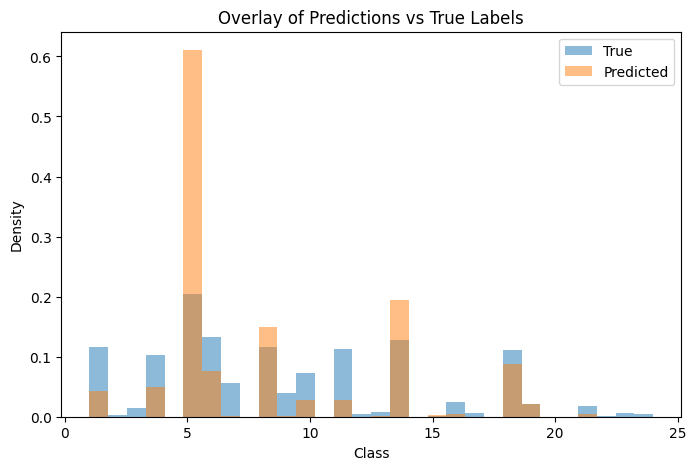

Jenson Shannon 0.24332575043765517


In [24]:
dist_match(df_pred_sub['y_test'], df_pred_sub['pred'])

In [25]:
df_preds.shape

(305835, 15)

### CLUSTER

In [ ]:
df_base_inp_1 = pd.read_csv("/mnt/c/Users/nahomw/Desktop/from_mac/nahomworku/Desktop/uthealth/gra_project/synthetic-population/data/raw/emergency/ED PUDF 1Q2023 tab-delimited (2)/IP_ED_BASE_DATA_1_1q2023_tab.txt",sep="\t", dtype=str)


In [ ]:
import pandas as pd
import numpy as np
import gower
from sklearn.cluster import DBSCAN

# --- SAMPLE DATA TO FIT IN MEMORY ---
df_cluster.sample(5000, random_state=42)

# Compute Gower distance (5000x5000 = OK)
gower_dist = gower.gower_matrix(df_cluster)

# Run DBSCAN on Gower distances
db = DBSCAN(eps=0.22, min_samples=10, metric="precomputed")
labels = db.fit_predict(gower_dist)

# Add cluster labels back to sample
df_cluster['Cluster'] = labels

print(df_cluster[['APR_MDC', 'Cluster']].head())
print("Unique clusters:", np.unique(labels))


: 

In [36]:
from sklearn.cluster import DBSCAN

# Assuming your data is in df_cluster
db = DBSCAN(eps=0.21, min_samples=5)  # adjust min_samples if needed
clusters = db.fit_predict(df_cluster)

df_cluster['Cluster'] = clusters
print(df_cluster['Cluster'].value_counts())


NameError: name 'df_cluster' is not defined

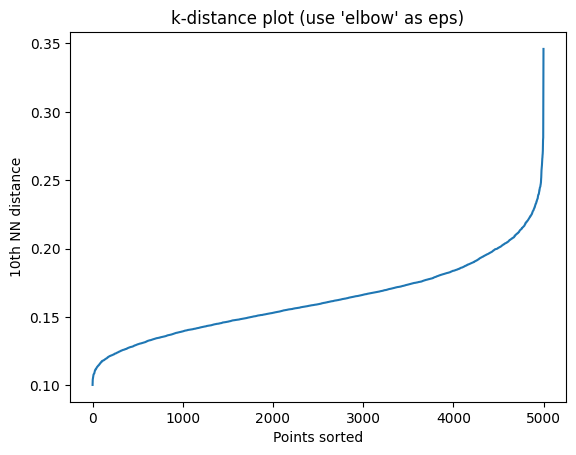

In [92]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

neigh = NearestNeighbors(n_neighbors=10, metric="precomputed")
neigh.fit(gower_dist)
distances, indices = neigh.kneighbors(gower_dist)

# Sort distances of the 10th neighbor
dist_sort = np.sort(distances[:, -1])
plt.plot(dist_sort)
plt.ylabel("10th NN distance")
plt.xlabel("Points sorted")
plt.title("k-distance plot (use 'elbow' as eps)")
plt.show()
